In [3]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv
import dask.bag as db
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import metrics
from hkfold import HKFold, train_test_split

In [4]:
dframe_path = 'data/cabauw/processed.csv'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df.sort_values(['ds', 'tt'])

lets start with a baseline. data doesnt follow the functions given in the literature, so while I fix it we can change those functions to fit the data. given the definition of $\phi_m$ for $\xi>0$:

$$
\phi_m(\xi)=a+b\xi
$$

whose derivatives are trivial. for $\xi<0$ we have

$$
\phi_m(\xi)=(1+c\xi)^d
$$

whose derivatives are

$$
\frac{\partial \phi_m}{\partial c}=\xi d(1+c\xi)^{d-1}
$$

$$
\frac{\partial \phi_m}{\partial d}=(1+c\xi)^d\ln(1+c\xi)
$$

considering the usual least squares with l2 regularization we have the loss function

$$
E=\frac{1}{N}\sum_i(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))^2+\frac{1}{2}\sum_p p^2
$$

and its derivative with respect to the parameter $p$

$$
\frac{\partial E}{\partial p}=\frac{2}{N}\sum_i\frac{\partial}{\partial p}\phi_m(\xi_i,p)\cdot(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))+p
$$

In [5]:
def phim(zL, a, b, c, d):
    mask = zL >= 0
    yy = np.zeros(len(zL))
    yy[mask] = a + b * zL[mask]
    yy[~mask] = np.power(1 + c * zL[~mask], d)
    assert all(np.isfinite(zL))
    assert all(np.isfinite(yy)), (a, b, c, d)
    return yy


def phim_prime(zL, a, b, c, d):
    dpda = np.ones(len(zL))
    dpdb = np.ones(len(zL)) * zL
    
    inner = 1 + c * zL
    dpdc = zL * d * np.power(inner, d - 1)
    dpdd = np.sign(inner) * np.log(np.abs(inner)) * np.power(inner, d)

    return dpda, dpdb, dpdc, dpdd

In [6]:
train_idx, test_idx = next(HKFold(KFold(250, shuffle=True), h=int(24 * 60 / 10)).split(df))
train_x, train_y = df.zL_m.iloc[train_idx], df.phi_m.iloc[train_idx]
test_x, test_y = df.zL_m.iloc[test_idx], df.phi_m.iloc[test_idx]

#train_x, test_x, train_y, test_y = train_test_split(df.zL_m.values, df.phi_m.values,
#                                                    h=int(24 * 60 / 10), test_size=5000)

print('training with %d samples, testing with %d' % (len(train_x), len(test_x)))

# can get much better results with this
#test_y -= 2
#train_y -= 2

params = [1, 4.8, -19.3, -0.25]
lrate = 0.025
regu = 0.1

for i in range(1000):
    preds = phim(train_x, *params)
    err = np.mean((train_y - preds)**2)
    der = phim_prime(train_x, *params)
    
    lr = lrate / np.sqrt(i + 1)
    for p, parpr in enumerate(der):
        grad = 2 * np.mean((preds - train_y) * parpr) + regu * params[p]
        params[p] -= lr * grad

    if i % 25 == 0:
        print(i, err, params)

training with 161504 samples, testing with 2084
0 5.092528582470241 [1.1038048170253005, 4.78088859452299, -19.301776593117662, -0.2618880556602607]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power


25 3.527391275101256 [1.8020246249606184, 4.6159545755415525, -19.32904342075244, -0.3227778230134178]
50 3.1072586250614007 [2.0971860730721588, 4.523081570584796, -22.389163074879043, -0.30782972167186257]
75 2.7779126046570437 [2.298552484248584, 4.449279694134657, -22.243648481907854, -0.2401878367915205]
100 2.4637653717304753 [2.4494151904906194, 4.387216712908531, -22.1058158930464, -0.13359111455408762]
125 2.109454039269577 [2.5662715145969925, 4.334570496790321, -21.977678567898952, 0.005495616292801667]
150 1.702835695040628 [2.656144970496455, 4.291547930398478, -21.86108025779387, 0.16564957045741038]
175 1.378884262014473 [2.72249397273818, 4.259733004124919, -21.754478329416873, 0.3049809099782486]
200 1.2742561295765806 [2.771367520080186, 4.237715952304523, -21.655944340436132, 0.370193697480319]
225 1.2491548185729298 [2.8110713877030937, 4.220201985156024, -21.563661559184307, 0.38672732205257043]
250 1.2349409089451557 [2.845825269361443, 4.204257559545675, -21.4766

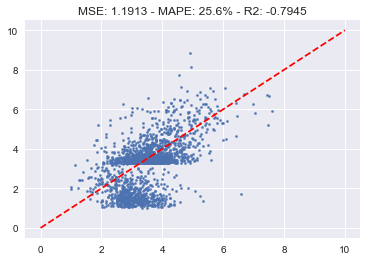

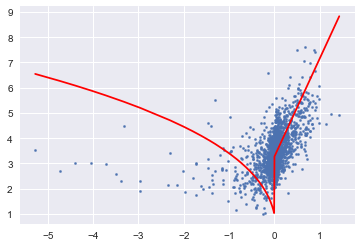

In [7]:
pred = phim(test_x, *params)
rmse = np.mean(np.power(pred - test_y, 2))
mape = np.mean(np.abs((pred - test_y) / test_y))  * 100
r2s = metrics.r2_score(test_y, pred)
plt.scatter(test_y, pred, s=5)
plt.title('MSE: %.4f - MAPE: %.1f%% - R2: %.4f' % (rmse, mape, r2s))
plt.plot([0, 10], [0, 10], 'r--')
plt.show()

plt.scatter(test_x, test_y, s=5)
plt.plot(test_x.sort_values(), phim(test_x.sort_values(), *params), 'r')
plt.show()

NB average percent error is kinda unfair due to extreme outliers in the left tail

NB by predicting phi_m-2 we can get results that are similar to those in the literature

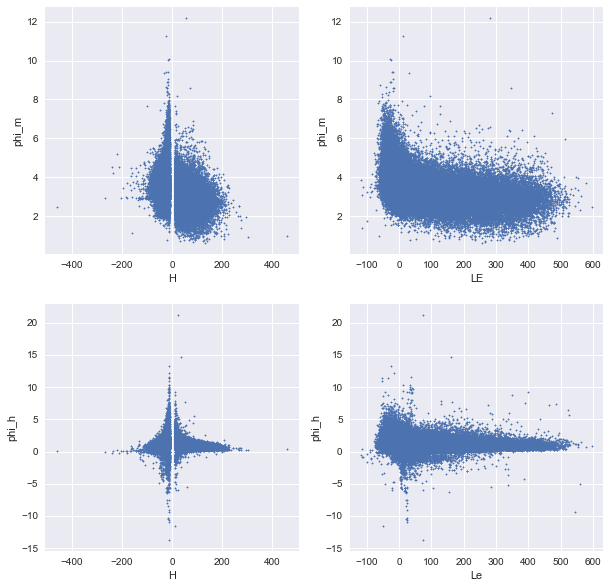

In [70]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.xlabel('H'); plt.ylabel('phi_m')
plt.scatter(df.H, df.phi_m, s=1)
plt.subplot(2, 2, 2); plt.xlabel('LE'); plt.ylabel('phi_m')
plt.scatter(df.LE, df.phi_m, s=1)
plt.subplot(2, 2, 3); plt.xlabel('H'); plt.ylabel('phi_h')
plt.scatter(df.H, df.phi_h, s=1)
plt.subplot(2, 2, 4); plt.xlabel('LEs'); plt.ylabel('phi_h')
plt.scatter(df.LE, df.phi_h, s=1)
plt.show()

In [10]:
def test_features(model, grid, features, target):
    results = []
    outer_cv = HKFold(KFold(5), h=int(7 * 24 * 60 / 10))
    
    for oi, (dev_idx, test_idx) in enumerate(outer_cv.split(df)):
        inner_cv = HKFold(KFold(5), h=int(7 * 24 * 60 / 10))
        gs = GridSearchCV(
            model, grid, n_jobs=-1, cv=inner_cv,
            scoring='neg_mean_squared_error',
        )
        gs.fit(df[features].iloc[dev_idx], df[target].iloc[dev_idx])

        y_pred = gs.best_estimator_.predict(df[features].iloc[test_idx])
        y_true = df[target].iloc[test_idx]

        results.append((
            metrics.explained_variance_score(y_true, y_pred),
            metrics.mean_absolute_error(y_true, y_pred),
            metrics.mean_squared_error(y_true, y_pred),
            metrics.mean_squared_log_error(y_true, y_pred),
            metrics.median_absolute_error(y_true, y_pred),
            metrics.r2_score(y_true, y_pred),
            np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        ))

    return pd.DataFrame(results, columns=[
        'explained_variance_score',
        'mean_absolute_error',
        'mean_squared_error',
        'mean_squared_log_error',
        'median_absolute_error',
        'r2_score',
        'mean_percent_error'
    ]).T
        

grid = {
    'n_neighbors': [1, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}


F1 = ['H', 'LE']
F2 = ['air_dens', 'surf_temp', 'spec_hum', 'rel_hum', 'press', 'rain']

In [ ]:
f1_res = test_features(KNeighborsRegressor(), grid, F1, 'phi_m')
f2_res = test_features(KNeighborsRegressor(), grid, F2, 'phi_m')
f12_res = test_features(KNeighborsRegressor(), grid, F1 + F2, 'phi_m')

In [75]:
f1_res.T.describe().T

,count,mean,std,min,25%,50%,75%,max
explained_variance_score,5.0,-0.022015,0.044863,-0.070755,-0.032654,-0.029716,-0.028803,0.051854
mean_absolute_error,5.0,0.621548,0.023010,0.597143,0.605424,0.613839,0.641236,0.650099
mean_squared_error,5.0,0.651353,0.048194,0.592651,0.619250,0.647052,0.687226,0.710588
mean_squared_log_error,5.0,0.032275,0.002234,0.030032,0.030858,0.031120,0.034662,0.034702
median_absolute_error,5.0,0.503608,0.020559,0.486753,0.486894,0.492471,0.524561,0.527361
r2_score,5.0,-0.028566,0.047190,-0.072262,-0.046516,-0.041997,-0.033908,0.051853
mean_percent_error,5.0,18.939090,1.128777,17.604709,18.216971,18.707167,19.836017,20.330584


In [76]:
f2_res.T.describe().T

,count,mean,std,min,25%,50%,75%,max
explained_variance_score,5.0,-0.402311,0.042020,-0.450320,-0.435293,-0.406381,-0.364030,-0.355533
mean_absolute_error,5.0,0.712969,0.018671,0.694272,0.699394,0.710770,0.718769,0.741641
mean_squared_error,5.0,0.890469,0.049708,0.839573,0.847388,0.900610,0.902221,0.962553
mean_squared_log_error,5.0,0.042893,0.002223,0.039767,0.041957,0.043007,0.044052,0.045680
median_absolute_error,5.0,0.563272,0.014699,0.551345,0.551556,0.556946,0.571341,0.585171
r2_score,5.0,-0.406837,0.044046,-0.452471,-0.441636,-0.418856,-0.365537,-0.355686
mean_percent_error,5.0,21.499657,1.033325,20.117599,20.743783,21.806132,22.319019,22.511750


In [77]:
f12_res.T.describe().T

,count,mean,std,min,25%,50%,75%,max
explained_variance_score,5.0,0.019704,0.063562,-0.040696,-0.036882,0.023015,0.038867,0.114215
mean_absolute_error,5.0,0.597269,0.024448,0.566625,0.587251,0.590426,0.611634,0.630409
mean_squared_error,5.0,0.621751,0.049289,0.553935,0.611433,0.615681,0.637107,0.690596
mean_squared_log_error,5.0,0.030266,0.001965,0.028577,0.028946,0.029112,0.031692,0.033002
median_absolute_error,5.0,0.475851,0.023405,0.453307,0.460642,0.463498,0.496240,0.505571
r2_score,5.0,0.017643,0.064203,-0.042094,-0.040484,0.023006,0.033996,0.113791
mean_percent_error,5.0,18.083002,0.921639,17.166908,17.417981,17.685282,19.064747,19.080092


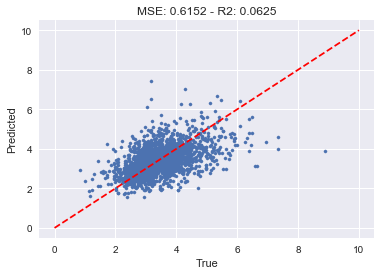

In [74]:
train_idx, test_idx = next(HKFold(KFold(250, shuffle=True), h=int(24 * 60 / 10)).split(df))

knr = KNeighborsRegressor(n_neighbors=10, weights='distance', p=2)
knr.fit(df[F1 + F2].iloc[train_idx], df.phi_m.iloc[train_idx])
y_true = df.phi_m.iloc[test_idx]
y_pred = knr.predict(df[F1 + F2].iloc[test_idx])

plt.scatter(y_true, y_pred, s=10)
plt.plot([0, 10], [0, 10], 'r--')
plt.title('MSE: %.4f - MAPE: %.1f - R2: %.4f' % (
    metrics.mean_squared_error(y_true, y_pred),
    100 * np.mean(np.abs((y_true - y_pred) / y_true)),
    metrics.r2_score(y_true, y_pred)
))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()